# **CIS 520: Machine Learning, Fall 2020**
# **Week 5, Worksheet 2**
## Neural Networks


- **Content Creators:** Yide Zhao, Mihir Parmar
- **Content Reviewers:**  Shaozhe Lyu, Michael Zhou, Tejas Srivastava




Learning Objectives:
* How to build a neural net in pytorch
* Understand different activation functions
* How to compute the number of weights in a neural net
* Understand different optimization methods


In [1]:
import os
import numpy as np
import torch
from torch import nn, optim
import torchvision
from torchvision import datasets, transforms
import matplotlib as mpl
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the data

In [2]:
trainset = datasets.MNIST('./data', download=True, train=True, transform=transforms.Compose([transforms.ToTensor()]))
testset = datasets.MNIST('./data', download=True, train=False, transform=transforms.Compose([transforms.ToTensor()]))

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Here, you can change the batch size from 16 to whatever number you like. You could try to change this number later once you learn how to train the network. Try to see how different batch size might influence the rate of convergence and accuracy.

In [3]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=True)

# **Visualize the data**

The label is:  tensor(0)
The label is:  tensor(5)
The label is:  tensor(2)




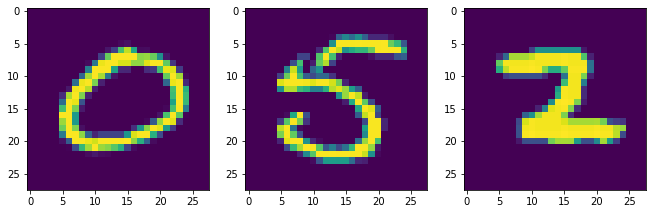

In [4]:
images, labels = iter(trainloader).next()
fig=plt.figure(figsize=(15, 10))
for i in range(1, 4):
    fig.add_subplot(1, 4, i)
    plt.imshow(images[i].numpy().squeeze())
    print('The label is: ', labels[i])
plt.show()

In [5]:
# print the shape of the label
print(labels.shape)

torch.Size([16])


This 16 here represents the batch size you determined before. 

## Exercise 1:
What's the dimension of the images? Hint: see how to figure out the dimension of the labels.

Answer: It's 28 * 28. Keep an eye on this number: when we later look at max-pooling and convolutional layer in CNN, getting your dimension right is THE MOST important thing in designing your own CNN.

In [6]:
print(images.shape)

torch.Size([16, 1, 28, 28])


# **Neural Network**

## Building deep feed-forward networks with *PyTorch*

We'll now build a simple deep neural network. Specifically, we'll build a deep network with three hidden layers with 10 neurons in each layer.

Let $\mathbf{r}^{(n)} = \begin{bmatrix} r_1^{(n)} & r_2^{(n)} & \ldots & r_N^{(n)} \end{bmatrix}^T$ denote the vector of neural responses (of neurons $1, \ldots, N$) to the $n$th stimulus. The network we will use is described by the following set of equations:
\begin{align}
    \mathbf{h}^{(n)} &= \mathbf{W}^{in} \mathbf{r}^{(n)} + \mathbf{b}^{in}, && [\mathbf{W}^{in}: M \times N], \\
    y^{(n)} &= \mathbf{W}^{out} \mathbf{h}^{(n)} + \mathbf{b}^{out},  && [\mathbf{W}^{out}: 1 \times M],
\end{align}
where $y^{(n)}$ denotes the scalar output of the network: the decoded orientation of the $n$th stimulus. 

The $M$-dimensional vector $\mathbf{h}^{(n)}$ denotes the activations of the **hidden layer** of the network. The reason it is called hidden can be glimpsed from the schematic below, showing how the hidden layer is, in a sense, "hidden" from the input and output of the network. Deeper networks may have multiple hidden layers, but here we'll just focus on a single hidden layer. 

<p align="center">
  <img src="https://github.com/NeuromatchAcademy/course-content/blob/master/tutorials/static/one-layer-network.png?raw=true" width="450" />
</p>

The following code shows a neural network in PyTorch, using the PyTorch `nn.Module` object class. It contains three key ingredients:

* `__init__()` method to initialize its parameters, like in any other Python class. It takes the following arguments: hidden_size which specifies the number of units in the hidden layer; input size; and num_class which is the number of classes depending on binary or multiclass classification.

* `nn.Linear()` modules, which are built-in PyTorch objects containing all the weights and biases for a given network layer. See [here](https://pytorch.org/docs/master/generated/torch.nn.Linear.html) for documentation. It takes two arguments:
   * \# of inputs to that layer, and 
   * \# of outputs from that layer

  For the input layer, for example, we have:
   * \# of inputs = \# of neurons whose responses are to be decoded ($N$)
   * \# of outputs = \# of hidden layer units ($M$)
  
  PyTorch will initialize all weights and biases randomly.

* `forward()` method, which takes as argument an input to the network and returns the network output. In our case, this comprises computing the output $y$ from a given input $\mathbf{r}$ using the above two equations. We provide the code for doing this using the built-in PyTorch `nn.Linear()` objects.

## Example 1: One layer feed-forward neural network

In [11]:
class NeuralNet1(nn.Module):
  def __init__(self, input, hiddensize = 100):
    super().__init__()  # needed to invoke the properties of the parent class nn.Module
    self.in_layer = nn.Linear(input, hiddensize)
    self.out_layer = nn.Linear(hiddensize, 10)

  def forward(self, x):
    x = self.in_layer(x)
    x = self.out_layer(x)
    return x

How many parameters are used in this Neural Network? 

To figure this out, we need to understand how 
many neurons are there in each layer (from input to hidden to output).

For the input layer, there are 784 = 28 * 28 neurons. For the hidden layer, there are 10 neurons. For the output layer, there are 10 neurons since there are 10 possible digits. Also, for the hidden layer, there will be 10 bias terms (which are also model parameters) and for the output layer there will be 10 bias terms. 

Given that for each neuron, there will be a weight (parameter) to every neurons in the next layer. The total number of parameters will be 784 * 10  + 10 * 10 + 10 +10 = 7960.

## Exercise 2:
1. Implement a Neural Network with 2 hidden layers where each layer has 12 neurons in the following code snippet. 
2. Calculate how many parameters are used in the Neural Network you just created.

In [14]:
class NeuralNet2(nn.Module):
  def __init__(self, input, hiddensize = 12):
    # TODO
    pass

  def forward(self, x):
    # TODO
    pass


# number_of_parameters = # TODO

### Solution

In [15]:
class NeuralNet2(nn.Module):
  def __init__(self, input, hiddensize = 12):
    super().__init__()
    self.first_layer = nn.Linear(input, hiddensize)
    self.second_layer = nn.Linear(hiddensize, hidden_size)
    self.out_layer = nn.Linear(hiddensize, 10)
    # TODO

  def forward(self, x):
    x = self.first_layer(x)
    x = self.second_layer(x)
    x = self.out_layer(x)
    # TODO


number_of_parameters = (784*12 +12*12+ 12*10 + 12+12+10 ) # TODO

## Key Component: Activation Function

Activation functions are used to implement nonlinear transformations from the input layer to the hidden layer. The activation function takes the following form:
\begin{equation}
    \mathbf{h}^{(n)} = \phi(\mathbf{W}^{in} \mathbf{r}^{(n)} + \mathbf{b}^{in})
\end{equation}
where $\phi$ is some nonlinear function, referred to as the **activation function**. 

One of the widely used activation functions is  "**Re**ctified **L**inear **U**nits", or **ReLU**'s, which can be implemented in PyTorch using `torch.relu()`. The **ReLU** has the following mathematical expression:
\begin{equation}
  \phi(x) = 
  \begin{cases}
    x & \text{if } x > 0 \\
    0 & \text{else}
  \end{cases}
\end{equation}

Another famous activation function is Sigmoid or Logistic Activation Function, often called **Sigmoid**, which can be implemented in PyTorch using `torch.sigmoid()`. The **Sigmoid** has the following mathematical expression:
\begin{equation}
\phi(x)=\frac{1}{1+e^{-x}}
\end{equation}

To learn more about [activation functions](https://towardsdatascience.com/activation-functions-neural-networks-1cbd9f8d91d6)

Now, we will look at the same neural network from Example 1 and we will apply a ReLU activation function in the hidden layer.

In [16]:
class NeuralNet3(nn.Module):
  def __init__(self, input, hiddensize = 100):
    super().__init__()  # needed to invoke the properties of the parent class nn.Module
    self.in_layer = nn.Linear(input, hiddensize)
    self.out_layer = nn.Linear(hiddensize, 10)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.relu(self.in_layer(x))
    x = self.out_layer(x)
    return x

## Exercise 3:
1. Add ReLU activation function to the 2 hidden layers of your model from Exercise 2.
2. How many parameters are there in the above network you just created?

In [ ]:
class NeuralNet4(nn.Module):
  def __init__(self, input, hiddensize):
    pass 
    # TODO

  def forward(self, x):
    pass
    # TODO

number_of_parameters = None # TODO

### Solution

In [17]:
class NeuralNet4(nn.Module):
  def __init__(self, input, hiddensize = 12):
    super().__init__()
    self.first_layer = nn.Linear(input, hiddensize)
    self.second_layer = nn.Linear(hiddensize, hidden_size)
    self.out_layer = nn.Linear(hiddensize, 10)
    self.relu = nn.ReLU()
    # TODO

  def forward(self, x):
    x = self.relu(self.first_layer(x))
    x = self.relu(self.second_layer(x))
    x = self.out_layer(x)
    return x
    # TODO


number_of_parameters = (784*12 +12*12+ 12*10 + 12+12+10 ) # TODO 
# number_of_parameters will remain same as the previous part, since there are no learnable parameters in ReLU

## Key Component: Loss Function

Because the weights of the network are currently randomly chosen, the outputs of the network are nonsense. We need to write some code to change these weights so that the network will be doing the job better. 

But to do so, we first need to define what we mean by "better". One simple way of defining this is to use the **squared error**
\begin{equation}
    L = (y - \tilde{y})^2
\end{equation}
where $y$ is the network output and $\tilde{y}$ is the true label. When the output of the nerual network is far from the true label, $L$ will be large. We thus refer to $L$ as the **loss function**, as it quantifies how *bad* the network is in doing the classification or regression task.

PyTorch actually already has a number of built-in loss functions. The one corresponding to squared error is called `nn.MSELoss()`. This will take as arguments a number of network outputs $y_1, y_2, \ldots, y_P$ and corresponding target outputs $\tilde{y}_1, \tilde{y}_2, \ldots, \tilde{y}_P$, and compute the **mean squared error (MSE)**
\begin{equation}
    L = \frac{1}{P}\sum_{n=1}^P \left(y^{(n)} - \tilde{y}^{(n)}\right)^2
\end{equation}

Another widely used loss function is called **cross entropy loss**, which takes the following mathematical expression:
\begin{equation}
\text { CrossEntropy Loss }=-\left(y_{i} \log \left(\hat{y}_{i}\right)+\left(1-y_{i}\right) \log \left(1-\hat{y}_{i}\right)\right)
\end{equation}

To learn more about [loss functions](https://towardsdatascience.com/common-loss-functions-in-machine-learning-46af0ffc4d23) 

## Key Component: Optimization method

Our goal is to modify the weights to make the loss $L$ as small as possible on the dataset. To do this, we'll use the **stochastic gradient descent (SGD)** algorithm, which consists of iterating four simple steps:
1. **Randomly sample a *mini-batch* of training data**. This is only strictly necessary when the full data set is too big to pass through the network all at once. That said, using mini-batches turns out to also help avoid overfitting.
2. **Evaluate the loss** at this mini-batch
3. **Compute the gradient of the loss** with respect to each of the network weights. In PyTorch, we can do this with one line of code: if the loss is stored in a variable `loss`, all you need to do is run
```
loss.backward()
```
PyTorch will then compute the gradients of this quantity with respect to each network parameter using [automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation), and store them behind the scenes.
4. **Update the network weights** by descending the gradient. In Pytorch, we can do this with one line of code by using built-in optimizers. The SGD optimizer is called `optim.SGD` (documentation [here](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD)), and takes as arguments 
  * the parameters to be updated
  * the learning rate to use

  For example, to optimize *all* the parameters of a network `net` using a learning rate of .001, one would use
  ```
  optimizer = optim.SGD(net.parameters(), lr=.001)
  ```
  where `.parameters()` is a method of the `nn.Module` class that returns a [Python generator object](https://wiki.python.org/moin/Generators) over all the parameters of that `nn.Module` class (in our case, $\mathbf{W}^{in}, \mathbf{b}^{in}, \mathbf{W}^{out}, \mathbf{b}^{out}$).
  
  To update each of these parameters, we then need only call the `.step()` method of this optimizer:
  ```
  optimizer.step()
  ```
  This single line of code will execute the SGD updates for each parameter given to the optimizer when it was initialized. Note that this is true no matter how big/small the network is, allowing us to use the same two lines of code for any deep network model built using PyTorch.

Finally, an important detail to remember is that the gradients of each parameter need to be cleared before calling `.backward()`, or else PyTorch will try to accumulate gradients across iterations. This can again be done using built-in optimizers via the method `zero_grad()`, as follows:
```
optimizer.zero_grad()
```

Other important optimization includes AdaGrad (Adaptive Gradient), RMSProp (Root Mean Square Propagation), and Adam (Adaptive Moment Estimation) which take advantage of both AdaGrad and RMSProp. Read this [following article](https://towardsdatascience.com/a-visual-explanation-of-gradient-descent-methods-momentum-adagrad-rmsprop-adam-f898b102325c) to learn more about the above three methods. 

## **Ready to Train!**
With the loss function and the optimization method, we will be able to train the models that we built. The following code give an example using CrossEntropy Loss and stochastic gradient descent (SGD). 

In [18]:
epochs = 15
input_size = 28*28
hidden_size = 100
model = NeuralNet3(input_size, hidden_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3) 
train_mse = []
# training iterations
for epoch in range(epochs):
    running_loss = 0
    for itr, (image, label) in enumerate(trainloader):
        # Flatten MNIST images into a 784 long vector
        image = image.view(image.shape[0], -1)
        # zero gradient
        optimizer.zero_grad()
        # forward path
        y_predicted = model(image)
        loss = criterion(y_predicted, label)
        running_loss += loss.item()
        # backpropagating
        loss.backward()
        # optimizes the weights
        optimizer.step()
    train_mse.append(running_loss)
    if (epoch+1) % 3 == 0:
        print(f'epoch: {epoch+1}, loss: {running_loss:.4f}')

epoch: 3, loss: 2304.9243
epoch: 6, loss: 1536.7387
epoch: 9, loss: 1331.3994
epoch: 12, loss: 1224.9721
epoch: 15, loss: 1151.9796


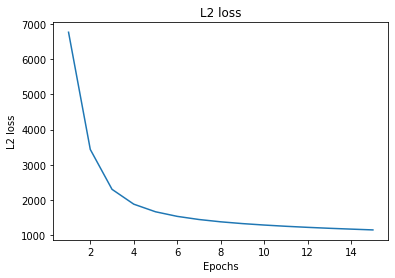

In [19]:
plt.plot(np.linspace(1, 15, 15), train_mse, label='Train')
plt.title('L2 loss')
plt.xlabel('Epochs')
plt.ylabel('L2 loss')
plt.show()

## Exercise 4:
1. Use stochastic gradient descent to train NeuralNet4 (from Exercise 3). You can pick the loss function and the number of epochs.
2. Use Adam to train NeuralNet4 (from Exercise 3). Use the same loss function and the number of epochs from Exercise 4.1.
3. Draw the training loss of 4.1 and 4.2 on the same graph. Compare the two curve and what do you find? Why is that? HINT: Read this [following article](https://towardsdatascience.com/a-visual-explanation-of-gradient-descent-methods-momentum-adagrad-rmsprop-adam-f898b102325c) to answer why. 

In [ ]:
# TODO 4.1


In [ ]:
# TODO 4.2

In [ ]:
# TODO 4.3

### Solution


In [20]:
# 4.1

epochs = 20
input_size = 28*28
hidden_size = 12
model = NeuralNet4(input_size, hidden_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=5e-4) 
train_mse = []
# training iterations
for epoch in range(epochs):
    running_loss = 0
    for itr, (image, label) in enumerate(trainloader):
        # Flatten MNIST images into a 784 long vector
        image = image.view(image.shape[0], -1)
        # zero gradient
        optimizer.zero_grad()
        # forward path
        y_predicted = model(image)
        loss = criterion(y_predicted, label)
        running_loss += loss.item()
        # backpropagating
        loss.backward()
        # optimizes the weights
        optimizer.step()
    train_mse.append(running_loss)
    if (epoch+1) % 3 == 0:
        print(f'epoch: {epoch+1}, loss: {running_loss:.4f}')

epoch: 3, loss: 7780.9252
epoch: 6, loss: 4642.9231
epoch: 9, loss: 2935.9875
epoch: 12, loss: 2221.4750
epoch: 15, loss: 1910.3644
epoch: 18, loss: 1742.8463


In [21]:
#4.2

epochs = 20
input_size = 28*28
hidden_size = 12
model = NeuralNet4(input_size, hidden_size)
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=5e-4) 
optimizer = optim.Adam(model.parameters(), lr = 5e-4)
train_mse_2 = []
# training iterations
for epoch in range(epochs):
    running_loss = 0
    for itr, (image, label) in enumerate(trainloader):
        # Flatten MNIST images into a 784 long vector
        image = image.view(image.shape[0], -1)
        # zero gradient
        optimizer.zero_grad()
        # forward path
        y_predicted = model(image)
        loss = criterion(y_predicted, label)
        running_loss += loss.item()
        # backpropagating
        loss.backward()
        # optimizes the weights
        optimizer.step()
    train_mse_2.append(running_loss)
    if (epoch+1) % 3 == 0:
        print(f'epoch: {epoch+1}, loss: {running_loss:.4f}')

epoch: 3, loss: 1031.1871
epoch: 6, loss: 804.1612
epoch: 9, loss: 697.4794
epoch: 12, loss: 637.7310
epoch: 15, loss: 601.4596
epoch: 18, loss: 575.3872


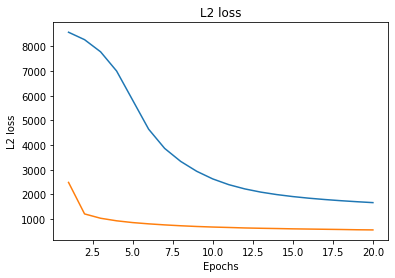

In [22]:
plt.plot(np.linspace(1, 20, 20), train_mse, label='Train')
plt.plot(np.linspace(1, 20, 20), train_mse_2, label='Train')
plt.title('L2 loss')
plt.xlabel('Epochs')
plt.ylabel('L2 loss')
plt.show()

## **Test your model!**
The last step is to test the model we built and trained. The following code shows the testing process.

In [24]:
correct = 0
total = 0
with torch.no_grad():
    for itr, (image, label) in enumerate(testloader):
        image = image.view(image.shape[0], -1)
        outputs = model(image)
        _, predicted = torch.max(outputs.data, 1)
        correct += predicted.eq(label.reshape(len(label),)).sum() 
        total += float(len(label))
    accuracy = correct / total
    print(f'Accuracy of Neural Network is {accuracy:.4f}')

Accuracy of Neural Network is 0.9459


## Exercise 5:
1. Test the accuracy of your model NeuralNet4 (from Exercise 3) 
2. Compare the test accuracy with my NeuralNet3 above. Which model has higher accuracy? Why do you think so?

In [23]:
# TODO



Accuracy of Neural Network is 0.9459


Answers:

References:
1. NeuromatchAcademy: https://github.com/NeuromatchAcademy/course-content/tree/master/tutorials/W3D4_DeepLearning1
2. https://towardsdatascience.com/handwritten-digit-mnist-pytorch-977b5338e627